# MCMC Supernova Recovery: Trial 2

In this notebook, I am going to start MCMC Supernova recovery again from the beginning.

In [157]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from lightkurve import KeplerTargetPixelFile
import numpy as np
import matplotlib.pyplot as plt
from lightkurve.injection import SupernovaModel
import lightkurve.injection as inj
import scipy.optimize as op

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [129]:
tpf = KeplerTargetPixelFile.from_archive(220381074) 

ConnectionError: HTTPSConnectionPool(host='mast.stsci.edu', port=443): Max retries exceeded with url: /api/v0/invoke (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x1c19ad5050>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known',))

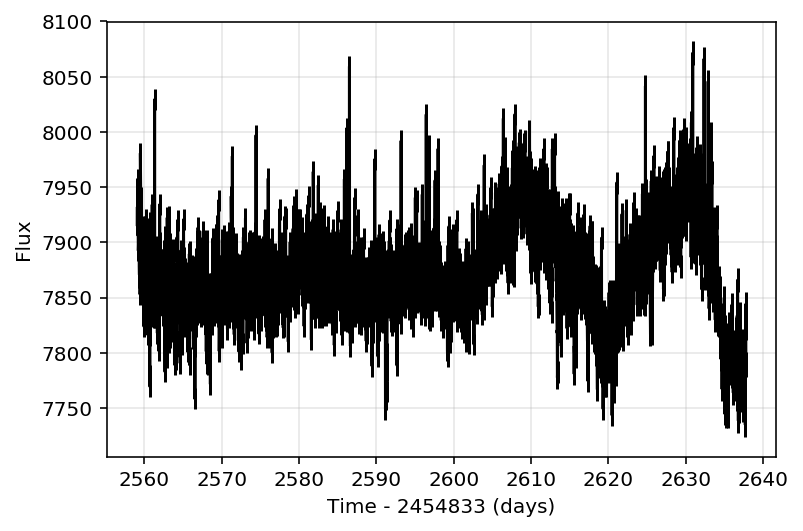

In [158]:
lc = tpf.to_lightcurve(aperture_mask='all') 
lc = lc.remove_nans().remove_outliers() 
lc.plot(normalize=False)

In [160]:
model = inj.SupernovaModel(T0=2600, source='hsiao', bandpass='kepler', z=0.5, amplitude=2.e-6)

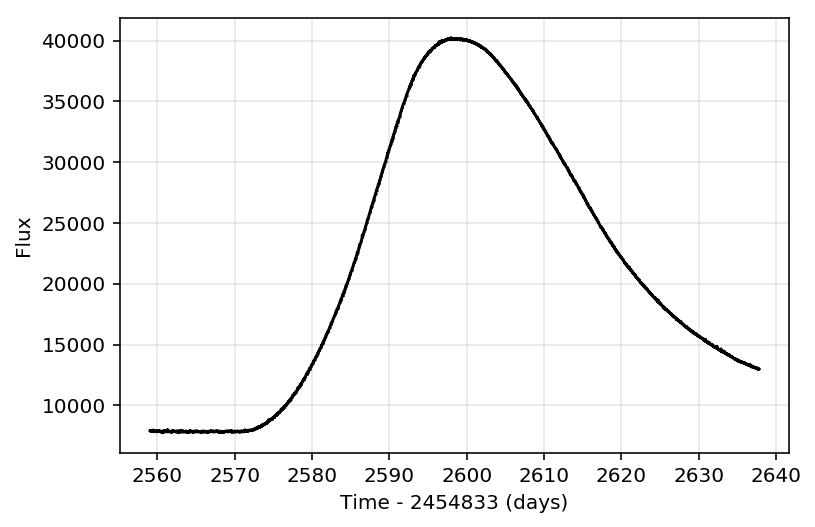

In [161]:
lcinj = inj.inject(lc, model)
lcinj = lcinj.remove_nans()
lcinj.plot(normalize=False)

In [196]:
def lnlike(theta):
    T0, z, amplitude = theta
    if (T0 < np.min(lc.time)) or (T0 > np.max(lc.time)) or (z < 0.0) or (z > 1.0) or (amplitude < 0.0) or (amplitude > 1.0):
        return -np.inf
    model = SupernovaModel(T0, z=z, amplitude=amplitude, source='hsiao', 
                           bandpass='kepler')
    model = model.evaluate(lc.time) + 7800 
    
    inv_sigma2 = 1.0/(lc.flux_err**2)
    chisq = (np.sum((lcinj.flux-model)**2*inv_sigma2))
    lnlikelihood = -0.5*chisq
    return lnlikelihood
    
    
    

In [197]:
def neg_ln_like(theta):
    return -1 * lnlike(theta)



In [198]:
lnlike([2610, 0.5, 2.e-7])

-5124956444.454376

In [199]:
neg_ln_like([2610, 0.5, 2.e-7])

5124956444.454376

In [200]:
def lnprior(theta):
    T0, z, amplitude = theta
    if np.min(lc.time) < T0 < np.max(lc.time) and 0.0 < z < 1.0 and 0.0 < amplitude < 1.0:
        return 0.0
    return -np.inf

In [201]:
lnprior([2560, 0.7, 4.e-7])

0.0

In [202]:
count=0
def lnprob(theta):
    global count
    count += 1
    print(count)
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta)

In [203]:
lnprob([2600, 0.5, 3.e-7])

1


-4397278958.042416

In [204]:
%%time
import scipy.optimize as op

#Injected values: T0=2600, z=0.5, amplitude=5e-8
x0 = [2610, 0.5, 3.0e-8]

result = op.minimize(lnprob, x0)
print(result)
T0_f, z_f, amplitude_f = result["x"]

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

In [214]:
ndim, nwalkers = 3, 100

In [215]:
pos = [[2595, 0.4, 3.e-7] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [216]:
import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

In [217]:
%%time
mcmc_result = sampler.run_mcmc(pos, 1000)

#real model: model = T0=2600, z=0.5, amplitude=2.e-7)

1655
1656
1657
1658
1659
1660
1661
1662
1663
1664
1665
1666
1667
1668
1669
1670
1671
1672
1673
1674
1675
1676
1677
1678
1679
1680
1681
1682
1683
1684
1685
1686
1687
1688
1689
1690
1691
1692
1693
1694
1695
1696
1697
1698
1699
1700
1701
1702
1703
1704
1705
1706
1707
1708
1709
1710
1711
1712
1713
1714
1715
1716
1717
1718
1719
1720
1721
1722
1723
1724
1725
1726
1727
1728
1729
1730
1731
1732
1733
1734
1735
1736
1737
1738
1739
1740
1741
1742
1743
1744
1745
1746
1747
1748
1749
1750
1751
1752
1753
1754
1755
1756
1757
1758
1759
1760
1761
1762
1763
1764
1765
1766
1767
1768
1769
1770
1771
1772
1773
1774
1775
1776
1777
1778
1779
1780
1781
1782
1783
1784
1785
1786
1787
1788
1789
1790
1791
1792
1793
1794
1795
1796
1797
1798
1799
1800
1801
1802
1803
1804
1805
1806
1807
1808
1809
1810
1811
1812
1813
1814
1815
1816
1817
1818
1819
1820
1821
1822
1823
1824
1825
1826
1827
1828
1829
1830
1831
1832
1833
1834
1835
1836
1837
1838
1839
1840
1841
1842
1843
1844
1845
1846
1847
1848
1849
1850
1851
1852
1853
1854


3298
3299
3300
3301
3302
3303
3304
3305
3306
3307
3308
3309
3310
3311
3312
3313
3314
3315
3316
3317
3318
3319
3320
3321
3322
3323
3324
3325
3326
3327
3328
3329
3330
3331
3332
3333
3334
3335
3336
3337
3338
3339
3340
3341
3342
3343
3344
3345
3346
3347
3348
3349
3350
3351
3352
3353
3354
3355
3356
3357
3358
3359
3360
3361
3362
3363
3364
3365
3366
3367
3368
3369
3370
3371
3372
3373
3374
3375
3376
3377
3378
3379
3380
3381
3382
3383
3384
3385
3386
3387
3388
3389
3390
3391
3392
3393
3394
3395
3396
3397
3398
3399
3400
3401
3402
3403
3404
3405
3406
3407
3408
3409
3410
3411
3412
3413
3414
3415
3416
3417
3418
3419
3420
3421
3422
3423
3424
3425
3426
3427
3428
3429
3430
3431
3432
3433
3434
3435
3436
3437
3438
3439
3440
3441
3442
3443
3444
3445
3446
3447
3448
3449
3450
3451
3452
3453
3454
3455
3456
3457
3458
3459
3460
3461
3462
3463
3464
3465
3466
3467
3468
3469
3470
3471
3472
3473
3474
3475
3476
3477
3478
3479
3480
3481
3482
3483
3484
3485
3486
3487
3488
3489
3490
3491
3492
3493
3494
3495
3496
3497


4938
4939
4940
4941
4942
4943
4944
4945
4946
4947
4948
4949
4950
4951
4952
4953
4954
4955
4956
4957
4958
4959
4960
4961
4962
4963
4964
4965
4966
4967
4968
4969
4970
4971
4972
4973
4974
4975
4976
4977
4978
4979
4980
4981
4982
4983
4984
4985
4986
4987
4988
4989
4990
4991
4992
4993
4994
4995
4996
4997
4998
4999
5000
5001
5002
5003
5004
5005
5006
5007
5008
5009
5010
5011
5012
5013
5014
5015
5016
5017
5018
5019
5020
5021
5022
5023
5024
5025
5026
5027
5028
5029
5030
5031
5032
5033
5034
5035
5036
5037
5038
5039
5040
5041
5042
5043
5044
5045
5046
5047
5048
5049
5050
5051
5052
5053
5054
5055
5056
5057
5058
5059
5060
5061
5062
5063
5064
5065
5066
5067
5068
5069
5070
5071
5072
5073
5074
5075
5076
5077
5078
5079
5080
5081
5082
5083
5084
5085
5086
5087
5088
5089
5090
5091
5092
5093
5094
5095
5096
5097
5098
5099
5100
5101
5102
5103
5104
5105
5106
5107
5108
5109
5110
5111
5112
5113
5114
5115
5116
5117
5118
5119
5120
5121
5122
5123
5124
5125
5126
5127
5128
5129
5130
5131
5132
5133
5134
5135
5136
5137


6580
6581
6582
6583
6584
6585
6586
6587
6588
6589
6590
6591
6592
6593
6594
6595
6596
6597
6598
6599
6600
6601
6602
6603
6604
6605
6606
6607
6608
6609
6610
6611
6612
6613
6614
6615
6616
6617
6618
6619
6620
6621
6622
6623
6624
6625
6626
6627
6628
6629
6630
6631
6632
6633
6634
6635
6636
6637
6638
6639
6640
6641
6642
6643
6644
6645
6646
6647
6648
6649
6650
6651
6652
6653
6654
6655
6656
6657
6658
6659
6660
6661
6662
6663
6664
6665
6666
6667
6668
6669
6670
6671
6672
6673
6674
6675
6676
6677
6678
6679
6680
6681
6682
6683
6684
6685
6686
6687
6688
6689
6690
6691
6692
6693
6694
6695
6696
6697
6698
6699
6700
6701
6702
6703
6704
6705
6706
6707
6708
6709
6710
6711
6712
6713
6714
6715
6716
6717
6718
6719
6720
6721
6722
6723
6724
6725
6726
6727
6728
6729
6730
6731
6732
6733
6734
6735
6736
6737
6738
6739
6740
6741
6742
6743
6744
6745
6746
6747
6748
6749
6750
6751
6752
6753
6754
6755
6756
6757
6758
6759
6760
6761
6762
6763
6764
6765
6766
6767
6768
6769
6770
6771
6772
6773
6774
6775
6776
6777
6778
6779


8219
8220
8221
8222
8223
8224
8225
8226
8227
8228
8229
8230
8231
8232
8233
8234
8235
8236
8237
8238
8239
8240
8241
8242
8243
8244
8245
8246
8247
8248
8249
8250
8251
8252
8253
8254
8255
8256
8257
8258
8259
8260
8261
8262
8263
8264
8265
8266
8267
8268
8269
8270
8271
8272
8273
8274
8275
8276
8277
8278
8279
8280
8281
8282
8283
8284
8285
8286
8287
8288
8289
8290
8291
8292
8293
8294
8295
8296
8297
8298
8299
8300
8301
8302
8303
8304
8305
8306
8307
8308
8309
8310
8311
8312
8313
8314
8315
8316
8317
8318
8319
8320
8321
8322
8323
8324
8325
8326
8327
8328
8329
8330
8331
8332
8333
8334
8335
8336
8337
8338
8339
8340
8341
8342
8343
8344
8345
8346
8347
8348
8349
8350
8351
8352
8353
8354
8355
8356
8357
8358
8359
8360
8361
8362
8363
8364
8365
8366
8367
8368
8369
8370
8371
8372
8373
8374
8375
8376
8377
8378
8379
8380
8381
8382
8383
8384
8385
8386
8387
8388
8389
8390
8391
8392
8393
8394
8395
8396
8397
8398
8399
8400
8401
8402
8403
8404
8405
8406
8407
8408
8409
8410
8411
8412
8413
8414
8415
8416
8417
8418


9858
9859
9860
9861
9862
9863
9864
9865
9866
9867
9868
9869
9870
9871
9872
9873
9874
9875
9876
9877
9878
9879
9880
9881
9882
9883
9884
9885
9886
9887
9888
9889
9890
9891
9892
9893
9894
9895
9896
9897
9898
9899
9900
9901
9902
9903
9904
9905
9906
9907
9908
9909
9910
9911
9912
9913
9914
9915
9916
9917
9918
9919
9920
9921
9922
9923
9924
9925
9926
9927
9928
9929
9930
9931
9932
9933
9934
9935
9936
9937
9938
9939
9940
9941
9942
9943
9944
9945
9946
9947
9948
9949
9950
9951
9952
9953
9954
9955
9956
9957
9958
9959
9960
9961
9962
9963
9964
9965
9966
9967
9968
9969
9970
9971
9972
9973
9974
9975
9976
9977
9978
9979
9980
9981
9982
9983
9984
9985
9986
9987
9988
9989
9990
9991
9992
9993
9994
9995
9996
9997
9998
9999
10000
10001
10002
10003
10004
10005
10006
10007
10008
10009
10010
10011
10012
10013
10014
10015
10016
10017
10018
10019
10020
10021
10022
10023
10024
10025
10026
10027
10028
10029
10030
10031
10032
10033
10034
10035
10036
10037
10038
10039
10040
10041
10042
10043
10044
10045
10046
10047
10

11248
11249
11250
11251
11252
11253
11254
11255
11256
11257
11258
11259
11260
11261
11262
11263
11264
11265
11266
11267
11268
11269
11270
11271
11272
11273
11274
11275
11276
11277
11278
11279
11280
11281
11282
11283
11284
11285
11286
11287
11288
11289
11290
11291
11292
11293
11294
11295
11296
11297
11298
11299
11300
11301
11302
11303
11304
11305
11306
11307
11308
11309
11310
11311
11312
11313
11314
11315
11316
11317
11318
11319
11320
11321
11322
11323
11324
11325
11326
11327
11328
11329
11330
11331
11332
11333
11334
11335
11336
11337
11338
11339
11340
11341
11342
11343
11344
11345
11346
11347
11348
11349
11350
11351
11352
11353
11354
11355
11356
11357
11358
11359
11360
11361
11362
11363
11364
11365
11366
11367
11368
11369
11370
11371
11372
11373
11374
11375
11376
11377
11378
11379
11380
11381
11382
11383
11384
11385
11386
11387
11388
11389
11390
11391
11392
11393
11394
11395
11396
11397
11398
11399
11400
11401
11402
11403
11404
11405
11406
11407
11408
11409
11410
11411
11412
11413
1141

12616
12617
12618
12619
12620
12621
12622
12623
12624
12625
12626
12627
12628
12629
12630
12631
12632
12633
12634
12635
12636
12637
12638
12639
12640
12641
12642
12643
12644
12645
12646
12647
12648
12649
12650
12651
12652
12653
12654
12655
12656
12657
12658
12659
12660
12661
12662
12663
12664
12665
12666
12667
12668
12669
12670
12671
12672
12673
12674
12675
12676
12677
12678
12679
12680
12681
12682
12683
12684
12685
12686
12687
12688
12689
12690
12691
12692
12693
12694
12695
12696
12697
12698
12699
12700
12701
12702
12703
12704
12705
12706
12707
12708
12709
12710
12711
12712
12713
12714
12715
12716
12717
12718
12719
12720
12721
12722
12723
12724
12725
12726
12727
12728
12729
12730
12731
12732
12733
12734
12735
12736
12737
12738
12739
12740
12741
12742
12743
12744
12745
12746
12747
12748
12749
12750
12751
12752
12753
12754
12755
12756
12757
12758
12759
12760
12761
12762
12763
12764
12765
12766
12767
12768
12769
12770
12771
12772
12773
12774
12775
12776
12777
12778
12779
12780
12781
1278

13982
13983
13984
13985
13986
13987
13988
13989
13990
13991
13992
13993
13994
13995
13996
13997
13998
13999
14000
14001
14002
14003
14004
14005
14006
14007
14008
14009
14010
14011
14012
14013
14014
14015
14016
14017
14018
14019
14020
14021
14022
14023
14024
14025
14026
14027
14028
14029
14030
14031
14032
14033
14034
14035
14036
14037
14038
14039
14040
14041
14042
14043
14044
14045
14046
14047
14048
14049
14050
14051
14052
14053
14054
14055
14056
14057
14058
14059
14060
14061
14062
14063
14064
14065
14066
14067
14068
14069
14070
14071
14072
14073
14074
14075
14076
14077
14078
14079
14080
14081
14082
14083
14084
14085
14086
14087
14088
14089
14090
14091
14092
14093
14094
14095
14096
14097
14098
14099
14100
14101
14102
14103
14104
14105
14106
14107
14108
14109
14110
14111
14112
14113
14114
14115
14116
14117
14118
14119
14120
14121
14122
14123
14124
14125
14126
14127
14128
14129
14130
14131
14132
14133
14134
14135
14136
14137
14138
14139
14140
14141
14142
14143
14144
14145
14146
14147
1414

15348
15349
15350
15351
15352
15353
15354
15355
15356
15357
15358
15359
15360
15361
15362
15363
15364
15365
15366
15367
15368
15369
15370
15371
15372
15373
15374
15375
15376
15377
15378
15379
15380
15381
15382
15383
15384
15385
15386
15387
15388
15389
15390
15391
15392
15393
15394
15395
15396
15397
15398
15399
15400
15401
15402
15403
15404
15405
15406
15407
15408
15409
15410
15411
15412
15413
15414
15415
15416
15417
15418
15419
15420
15421
15422
15423
15424
15425
15426
15427
15428
15429
15430
15431
15432
15433
15434
15435
15436
15437
15438
15439
15440
15441
15442
15443
15444
15445
15446
15447
15448
15449
15450
15451
15452
15453
15454
15455
15456
15457
15458
15459
15460
15461
15462
15463
15464
15465
15466
15467
15468
15469
15470
15471
15472
15473
15474
15475
15476
15477
15478
15479
15480
15481
15482
15483
15484
15485
15486
15487
15488
15489
15490
15491
15492
15493
15494
15495
15496
15497
15498
15499
15500
15501
15502
15503
15504
15505
15506
15507
15508
15509
15510
15511
15512
15513
1551

16717
16718
16719
16720
16721
16722
16723
16724
16725
16726
16727
16728
16729
16730
16731
16732
16733
16734
16735
16736
16737
16738
16739
16740
16741
16742
16743
16744
16745
16746
16747
16748
16749
16750
16751
16752
16753
16754
16755
16756
16757
16758
16759
16760
16761
16762
16763
16764
16765
16766
16767
16768
16769
16770
16771
16772
16773
16774
16775
16776
16777
16778
16779
16780
16781
16782
16783
16784
16785
16786
16787
16788
16789
16790
16791
16792
16793
16794
16795
16796
16797
16798
16799
16800
16801
16802
16803
16804
16805
16806
16807
16808
16809
16810
16811
16812
16813
16814
16815
16816
16817
16818
16819
16820
16821
16822
16823
16824
16825
16826
16827
16828
16829
16830
16831
16832
16833
16834
16835
16836
16837
16838
16839
16840
16841
16842
16843
16844
16845
16846
16847
16848
16849
16850
16851
16852
16853
16854
16855
16856
16857
16858
16859
16860
16861
16862
16863
16864
16865
16866
16867
16868
16869
16870
16871
16872
16873
16874
16875
16876
16877
16878
16879
16880
16881
16882
1688

18085
18086
18087
18088
18089
18090
18091
18092
18093
18094
18095
18096
18097
18098
18099
18100
18101
18102
18103
18104
18105
18106
18107
18108
18109
18110
18111
18112
18113
18114
18115
18116
18117
18118
18119
18120
18121
18122
18123
18124
18125
18126
18127
18128
18129
18130
18131
18132
18133
18134
18135
18136
18137
18138
18139
18140
18141
18142
18143
18144
18145
18146
18147
18148
18149
18150
18151
18152
18153
18154
18155
18156
18157
18158
18159
18160
18161
18162
18163
18164
18165
18166
18167
18168
18169
18170
18171
18172
18173
18174
18175
18176
18177
18178
18179
18180
18181
18182
18183
18184
18185
18186
18187
18188
18189
18190
18191
18192
18193
18194
18195
18196
18197
18198
18199
18200
18201
18202
18203
18204
18205
18206
18207
18208
18209
18210
18211
18212
18213
18214
18215
18216
18217
18218
18219
18220
18221
18222
18223
18224
18225
18226
18227
18228
18229
18230
18231
18232
18233
18234
18235
18236
18237
18238
18239
18240
18241
18242
18243
18244
18245
18246
18247
18248
18249
18250
1825

19451
19452
19453
19454
19455
19456
19457
19458
19459
19460
19461
19462
19463
19464
19465
19466
19467
19468
19469
19470
19471
19472
19473
19474
19475
19476
19477
19478
19479
19480
19481
19482
19483
19484
19485
19486
19487
19488
19489
19490
19491
19492
19493
19494
19495
19496
19497
19498
19499
19500
19501
19502
19503
19504
19505
19506
19507
19508
19509
19510
19511
19512
19513
19514
19515
19516
19517
19518
19519
19520
19521
19522
19523
19524
19525
19526
19527
19528
19529
19530
19531
19532
19533
19534
19535
19536
19537
19538
19539
19540
19541
19542
19543
19544
19545
19546
19547
19548
19549
19550
19551
19552
19553
19554
19555
19556
19557
19558
19559
19560
19561
19562
19563
19564
19565
19566
19567
19568
19569
19570
19571
19572
19573
19574
19575
19576
19577
19578
19579
19580
19581
19582
19583
19584
19585
19586
19587
19588
19589
19590
19591
19592
19593
19594
19595
19596
19597
19598
19599
19600
19601
19602
19603
19604
19605
19606
19607
19608
19609
19610
19611
19612
19613
19614
19615
19616
1961

20817
20818
20819
20820
20821
20822
20823
20824
20825
20826
20827
20828
20829
20830
20831
20832
20833
20834
20835
20836
20837
20838
20839
20840
20841
20842
20843
20844
20845
20846
20847
20848
20849
20850
20851
20852
20853
20854
20855
20856
20857
20858
20859
20860
20861
20862
20863
20864
20865
20866
20867
20868
20869
20870
20871
20872
20873
20874
20875
20876
20877
20878
20879
20880
20881
20882
20883
20884
20885
20886
20887
20888
20889
20890
20891
20892
20893
20894
20895
20896
20897
20898
20899
20900
20901
20902
20903
20904
20905
20906
20907
20908
20909
20910
20911
20912
20913
20914
20915
20916
20917
20918
20919
20920
20921
20922
20923
20924
20925
20926
20927
20928
20929
20930
20931
20932
20933
20934
20935
20936
20937
20938
20939
20940
20941
20942
20943
20944
20945
20946
20947
20948
20949
20950
20951
20952
20953
20954
20955
20956
20957
20958
20959
20960
20961
20962
20963
20964
20965
20966
20967
20968
20969
20970
20971
20972
20973
20974
20975
20976
20977
20978
20979
20980
20981
20982
2098

22184
22185
22186
22187
22188
22189
22190
22191
22192
22193
22194
22195
22196
22197
22198
22199
22200
22201
22202
22203
22204
22205
22206
22207
22208
22209
22210
22211
22212
22213
22214
22215
22216
22217
22218
22219
22220
22221
22222
22223
22224
22225
22226
22227
22228
22229
22230
22231
22232
22233
22234
22235
22236
22237
22238
22239
22240
22241
22242
22243
22244
22245
22246
22247
22248
22249
22250
22251
22252
22253
22254
22255
22256
22257
22258
22259
22260
22261
22262
22263
22264
22265
22266
22267
22268
22269
22270
22271
22272
22273
22274
22275
22276
22277
22278
22279
22280
22281
22282
22283
22284
22285
22286
22287
22288
22289
22290
22291
22292
22293
22294
22295
22296
22297
22298
22299
22300
22301
22302
22303
22304
22305
22306
22307
22308
22309
22310
22311
22312
22313
22314
22315
22316
22317
22318
22319
22320
22321
22322
22323
22324
22325
22326
22327
22328
22329
22330
22331
22332
22333
22334
22335
22336
22337
22338
22339
22340
22341
22342
22343
22344
22345
22346
22347
22348
22349
2235

23551
23552
23553
23554
23555
23556
23557
23558
23559
23560
23561
23562
23563
23564
23565
23566
23567
23568
23569
23570
23571
23572
23573
23574
23575
23576
23577
23578
23579
23580
23581
23582
23583
23584
23585
23586
23587
23588
23589
23590
23591
23592
23593
23594
23595
23596
23597
23598
23599
23600
23601
23602
23603
23604
23605
23606
23607
23608
23609
23610
23611
23612
23613
23614
23615
23616
23617
23618
23619
23620
23621
23622
23623
23624
23625
23626
23627
23628
23629
23630
23631
23632
23633
23634
23635
23636
23637
23638
23639
23640
23641
23642
23643
23644
23645
23646
23647
23648
23649
23650
23651
23652
23653
23654
23655
23656
23657
23658
23659
23660
23661
23662
23663
23664
23665
23666
23667
23668
23669
23670
23671
23672
23673
23674
23675
23676
23677
23678
23679
23680
23681
23682
23683
23684
23685
23686
23687
23688
23689
23690
23691
23692
23693
23694
23695
23696
23697
23698
23699
23700
23701
23702
23703
23704
23705
23706
23707
23708
23709
23710
23711
23712
23713
23714
23715
23716
2371

24917
24918
24919
24920
24921
24922
24923
24924
24925
24926
24927
24928
24929
24930
24931
24932
24933
24934
24935
24936
24937
24938
24939
24940
24941
24942
24943
24944
24945
24946
24947
24948
24949
24950
24951
24952
24953
24954
24955
24956
24957
24958
24959
24960
24961
24962
24963
24964
24965
24966
24967
24968
24969
24970
24971
24972
24973
24974
24975
24976
24977
24978
24979
24980
24981
24982
24983
24984
24985
24986
24987
24988
24989
24990
24991
24992
24993
24994
24995
24996
24997
24998
24999
25000
25001
25002
25003
25004
25005
25006
25007
25008
25009
25010
25011
25012
25013
25014
25015
25016
25017
25018
25019
25020
25021
25022
25023
25024
25025
25026
25027
25028
25029
25030
25031
25032
25033
25034
25035
25036
25037
25038
25039
25040
25041
25042
25043
25044
25045
25046
25047
25048
25049
25050
25051
25052
25053
25054
25055
25056
25057
25058
25059
25060
25061
25062
25063
25064
25065
25066
25067
25068
25069
25070
25071
25072
25073
25074
25075
25076
25077
25078
25079
25080
25081
25082
2508

26285
26286
26287
26288
26289
26290
26291
26292
26293
26294
26295
26296
26297
26298
26299
26300
26301
26302
26303
26304
26305
26306
26307
26308
26309
26310
26311
26312
26313
26314
26315
26316
26317
26318
26319
26320
26321
26322
26323
26324
26325
26326
26327
26328
26329
26330
26331
26332
26333
26334
26335
26336
26337
26338
26339
26340
26341
26342
26343
26344
26345
26346
26347
26348
26349
26350
26351
26352
26353
26354
26355
26356
26357
26358
26359
26360
26361
26362
26363
26364
26365
26366
26367
26368
26369
26370
26371
26372
26373
26374
26375
26376
26377
26378
26379
26380
26381
26382
26383
26384
26385
26386
26387
26388
26389
26390
26391
26392
26393
26394
26395
26396
26397
26398
26399
26400
26401
26402
26403
26404
26405
26406
26407
26408
26409
26410
26411
26412
26413
26414
26415
26416
26417
26418
26419
26420
26421
26422
26423
26424
26425
26426
26427
26428
26429
26430
26431
26432
26433
26434
26435
26436
26437
26438
26439
26440
26441
26442
26443
26444
26445
26446
26447
26448
26449
26450
2645

27651
27652
27653
27654
27655
27656
27657
27658
27659
27660
27661
27662
27663
27664
27665
27666
27667
27668
27669
27670
27671
27672
27673
27674
27675
27676
27677
27678
27679
27680
27681
27682
27683
27684
27685
27686
27687
27688
27689
27690
27691
27692
27693
27694
27695
27696
27697
27698
27699
27700
27701
27702
27703
27704
27705
27706
27707
27708
27709
27710
27711
27712
27713
27714
27715
27716
27717
27718
27719
27720
27721
27722
27723
27724
27725
27726
27727
27728
27729
27730
27731
27732
27733
27734
27735
27736
27737
27738
27739
27740
27741
27742
27743
27744
27745
27746
27747
27748
27749
27750
27751
27752
27753
27754
27755
27756
27757
27758
27759
27760
27761
27762
27763
27764
27765
27766
27767
27768
27769
27770
27771
27772
27773
27774
27775
27776
27777
27778
27779
27780
27781
27782
27783
27784
27785
27786
27787
27788
27789
27790
27791
27792
27793
27794
27795
27796
27797
27798
27799
27800
27801
27802
27803
27804
27805
27806
27807
27808
27809
27810
27811
27812
27813
27814
27815
27816
2781

29017
29018
29019
29020
29021
29022
29023
29024
29025
29026
29027
29028
29029
29030
29031
29032
29033
29034
29035
29036
29037
29038
29039
29040
29041
29042
29043
29044
29045
29046
29047
29048
29049
29050
29051
29052
29053
29054
29055
29056
29057
29058
29059
29060
29061
29062
29063
29064
29065
29066
29067
29068
29069
29070
29071
29072
29073
29074
29075
29076
29077
29078
29079
29080
29081
29082
29083
29084
29085
29086
29087
29088
29089
29090
29091
29092
29093
29094
29095
29096
29097
29098
29099
29100
29101
29102
29103
29104
29105
29106
29107
29108
29109
29110
29111
29112
29113
29114
29115
29116
29117
29118
29119
29120
29121
29122
29123
29124
29125
29126
29127
29128
29129
29130
29131
29132
29133
29134
29135
29136
29137
29138
29139
29140
29141
29142
29143
29144
29145
29146
29147
29148
29149
29150
29151
29152
29153
29154
29155
29156
29157
29158
29159
29160
29161
29162
29163
29164
29165
29166
29167
29168
29169
29170
29171
29172
29173
29174
29175
29176
29177
29178
29179
29180
29181
29182
2918

30384
30385
30386
30387
30388
30389
30390
30391
30392
30393
30394
30395
30396
30397
30398
30399
30400
30401
30402
30403
30404
30405
30406
30407
30408
30409
30410
30411
30412
30413
30414
30415
30416
30417
30418
30419
30420
30421
30422
30423
30424
30425
30426
30427
30428
30429
30430
30431
30432
30433
30434
30435
30436
30437
30438
30439
30440
30441
30442
30443
30444
30445
30446
30447
30448
30449
30450
30451
30452
30453
30454
30455
30456
30457
30458
30459
30460
30461
30462
30463
30464
30465
30466
30467
30468
30469
30470
30471
30472
30473
30474
30475
30476
30477
30478
30479
30480
30481
30482
30483
30484
30485
30486
30487
30488
30489
30490
30491
30492
30493
30494
30495
30496
30497
30498
30499
30500
30501
30502
30503
30504
30505
30506
30507
30508
30509
30510
30511
30512
30513
30514
30515
30516
30517
30518
30519
30520
30521
30522
30523
30524
30525
30526
30527
30528
30529
30530
30531
30532
30533
30534
30535
30536
30537
30538
30539
30540
30541
30542
30543
30544
30545
30546
30547
30548
30549
3055

31754
31755
31756
31757
31758
31759
31760
31761
31762
31763
31764
31765
31766
31767
31768
31769
31770
31771
31772
31773
31774
31775
31776
31777
31778
31779
31780
31781
31782
31783
31784
31785
31786
31787
31788
31789
31790
31791
31792
31793
31794
31795
31796
31797
31798
31799
31800
31801
31802
31803
31804
31805
31806
31807
31808
31809
31810
31811
31812
31813
31814
31815
31816
31817
31818
31819
31820
31821
31822
31823
31824
31825
31826
31827
31828
31829
31830
31831
31832
31833
31834
31835
31836
31837
31838
31839
31840
31841
31842
31843
31844
31845
31846
31847
31848
31849
31850
31851
31852
31853
31854
31855
31856
31857
31858
31859
31860
31861
31862
31863
31864
31865
31866
31867
31868
31869
31870
31871
31872
31873
31874
31875
31876
31877
31878
31879
31880
31881
31882
31883
31884
31885
31886
31887
31888
31889
31890
31891
31892
31893
31894
31895
31896
31897
31898
31899
31900
31901
31902
31903
31904
31905
31906
31907
31908
31909
31910
31911
31912
31913
31914
31915
31916
31917
31918
31919
3192

33120
33121
33122
33123
33124
33125
33126
33127
33128
33129
33130
33131
33132
33133
33134
33135
33136
33137
33138
33139
33140
33141
33142
33143
33144
33145
33146
33147
33148
33149
33150
33151
33152
33153
33154
33155
33156
33157
33158
33159
33160
33161
33162
33163
33164
33165
33166
33167
33168
33169
33170
33171
33172
33173
33174
33175
33176
33177
33178
33179
33180
33181
33182
33183
33184
33185
33186
33187
33188
33189
33190
33191
33192
33193
33194
33195
33196
33197
33198
33199
33200
33201
33202
33203
33204
33205
33206
33207
33208
33209
33210
33211
33212
33213
33214
33215
33216
33217
33218
33219
33220
33221
33222
33223
33224
33225
33226
33227
33228
33229
33230
33231
33232
33233
33234
33235
33236
33237
33238
33239
33240
33241
33242
33243
33244
33245
33246
33247
33248
33249
33250
33251
33252
33253
33254
33255
33256
33257
33258
33259
33260
33261
33262
33263
33264
33265
33266
33267
33268
33269
33270
33271
33272
33273
33274
33275
33276
33277
33278
33279
33280
33281
33282
33283
33284
33285
3328

34487
34488
34489
34490
34491
34492
34493
34494
34495
34496
34497
34498
34499
34500
34501
34502
34503
34504
34505
34506
34507
34508
34509
34510
34511
34512
34513
34514
34515
34516
34517
34518
34519
34520
34521
34522
34523
34524
34525
34526
34527
34528
34529
34530
34531
34532
34533
34534
34535
34536
34537
34538
34539
34540
34541
34542
34543
34544
34545
34546
34547
34548
34549
34550
34551
34552
34553
34554
34555
34556
34557
34558
34559
34560
34561
34562
34563
34564
34565
34566
34567
34568
34569
34570
34571
34572
34573
34574
34575
34576
34577
34578
34579
34580
34581
34582
34583
34584
34585
34586
34587
34588
34589
34590
34591
34592
34593
34594
34595
34596
34597
34598
34599
34600
34601
34602
34603
34604
34605
34606
34607
34608
34609
34610
34611
34612
34613
34614
34615
34616
34617
34618
34619
34620
34621
34622
34623
34624
34625
34626
34627
34628
34629
34630
34631
34632
34633
34634
34635
34636
34637
34638
34639
34640
34641
34642
34643
34644
34645
34646
34647
34648
34649
34650
34651
34652
3465

35854
35855
35856
35857
35858
35859
35860
35861
35862
35863
35864
35865
35866
35867
35868
35869
35870
35871
35872
35873
35874
35875
35876
35877
35878
35879
35880
35881
35882
35883
35884
35885
35886
35887
35888
35889
35890
35891
35892
35893
35894
35895
35896
35897
35898
35899
35900
35901
35902
35903
35904
35905
35906
35907
35908
35909
35910
35911
35912
35913
35914
35915
35916
35917
35918
35919
35920
35921
35922
35923
35924
35925
35926
35927
35928
35929
35930
35931
35932
35933
35934
35935
35936
35937
35938
35939
35940
35941
35942
35943
35944
35945
35946
35947
35948
35949
35950
35951
35952
35953
35954
35955
35956
35957
35958
35959
35960
35961
35962
35963
35964
35965
35966
35967
35968
35969
35970
35971
35972
35973
35974
35975
35976
35977
35978
35979
35980
35981
35982
35983
35984
35985
35986
35987
35988
35989
35990
35991
35992
35993
35994
35995
35996
35997
35998
35999
36000
36001
36002
36003
36004
36005
36006
36007
36008
36009
36010
36011
36012
36013
36014
36015
36016
36017
36018
36019
3602

37221
37222
37223
37224
37225
37226
37227
37228
37229
37230
37231
37232
37233
37234
37235
37236
37237
37238
37239
37240
37241
37242
37243
37244
37245
37246
37247
37248
37249
37250
37251
37252
37253
37254
37255
37256
37257
37258
37259
37260
37261
37262
37263
37264
37265
37266
37267
37268
37269
37270
37271
37272
37273
37274
37275
37276
37277
37278
37279
37280
37281
37282
37283
37284
37285
37286
37287
37288
37289
37290
37291
37292
37293
37294
37295
37296
37297
37298
37299
37300
37301
37302
37303
37304
37305
37306
37307
37308
37309
37310
37311
37312
37313
37314
37315
37316
37317
37318
37319
37320
37321
37322
37323
37324
37325
37326
37327
37328
37329
37330
37331
37332
37333
37334
37335
37336
37337
37338
37339
37340
37341
37342
37343
37344
37345
37346
37347
37348
37349
37350
37351
37352
37353
37354
37355
37356
37357
37358
37359
37360
37361
37362
37363
37364
37365
37366
37367
37368
37369
37370
37371
37372
37373
37374
37375
37376
37377
37378
37379
37380
37381
37382
37383
37384
37385
37386
3738

38587
38588
38589
38590
38591
38592
38593
38594
38595
38596
38597
38598
38599
38600
38601
38602
38603
38604
38605
38606
38607
38608
38609
38610
38611
38612
38613
38614
38615
38616
38617
38618
38619
38620
38621
38622
38623
38624
38625
38626
38627
38628
38629
38630
38631
38632
38633
38634
38635
38636
38637
38638
38639
38640
38641
38642
38643
38644
38645
38646
38647
38648
38649
38650
38651
38652
38653
38654
38655
38656
38657
38658
38659
38660
38661
38662
38663
38664
38665
38666
38667
38668
38669
38670
38671
38672
38673
38674
38675
38676
38677
38678
38679
38680
38681
38682
38683
38684
38685
38686
38687
38688
38689
38690
38691
38692
38693
38694
38695
38696
38697
38698
38699
38700
38701
38702
38703
38704
38705
38706
38707
38708
38709
38710
38711
38712
38713
38714
38715
38716
38717
38718
38719
38720
38721
38722
38723
38724
38725
38726
38727
38728
38729
38730
38731
38732
38733
38734
38735
38736
38737
38738
38739
38740
38741
38742
38743
38744
38745
38746
38747
38748
38749
38750
38751
38752
3875

39954
39955
39956
39957
39958
39959
39960
39961
39962
39963
39964
39965
39966
39967
39968
39969
39970
39971
39972
39973
39974
39975
39976
39977
39978
39979
39980
39981
39982
39983
39984
39985
39986
39987
39988
39989
39990
39991
39992
39993
39994
39995
39996
39997
39998
39999
40000
40001
40002
40003
40004
40005
40006
40007
40008
40009
40010
40011
40012
40013
40014
40015
40016
40017
40018
40019
40020
40021
40022
40023
40024
40025
40026
40027
40028
40029
40030
40031
40032
40033
40034
40035
40036
40037
40038
40039
40040
40041
40042
40043
40044
40045
40046
40047
40048
40049
40050
40051
40052
40053
40054
40055
40056
40057
40058
40059
40060
40061
40062
40063
40064
40065
40066
40067
40068
40069
40070
40071
40072
40073
40074
40075
40076
40077
40078
40079
40080
40081
40082
40083
40084
40085
40086
40087
40088
40089
40090
40091
40092
40093
40094
40095
40096
40097
40098
40099
40100
40101
40102
40103
40104
40105
40106
40107
40108
40109
40110
40111
40112
40113
40114
40115
40116
40117
40118
40119
4012

41320
41321
41322
41323
41324
41325
41326
41327
41328
41329
41330
41331
41332
41333
41334
41335
41336
41337
41338
41339
41340
41341
41342
41343
41344
41345
41346
41347
41348
41349
41350
41351
41352
41353
41354
41355
41356
41357
41358
41359
41360
41361
41362
41363
41364
41365
41366
41367
41368
41369
41370
41371
41372
41373
41374
41375
41376
41377
41378
41379
41380
41381
41382
41383
41384
41385
41386
41387
41388
41389
41390
41391
41392
41393
41394
41395
41396
41397
41398
41399
41400
41401
41402
41403
41404
41405
41406
41407
41408
41409
41410
41411
41412
41413
41414
41415
41416
41417
41418
41419
41420
41421
41422
41423
41424
41425
41426
41427
41428
41429
41430
41431
41432
41433
41434
41435
41436
41437
41438
41439
41440
41441
41442
41443
41444
41445
41446
41447
41448
41449
41450
41451
41452
41453
41454
41455
41456
41457
41458
41459
41460
41461
41462
41463
41464
41465
41466
41467
41468
41469
41470
41471
41472
41473
41474
41475
41476
41477
41478
41479
41480
41481
41482
41483
41484
41485
4148

42687
42688
42689
42690
42691
42692
42693
42694
42695
42696
42697
42698
42699
42700
42701
42702
42703
42704
42705
42706
42707
42708
42709
42710
42711
42712
42713
42714
42715
42716
42717
42718
42719
42720
42721
42722
42723
42724
42725
42726
42727
42728
42729
42730
42731
42732
42733
42734
42735
42736
42737
42738
42739
42740
42741
42742
42743
42744
42745
42746
42747
42748
42749
42750
42751
42752
42753
42754
42755
42756
42757
42758
42759
42760
42761
42762
42763
42764
42765
42766
42767
42768
42769
42770
42771
42772
42773
42774
42775
42776
42777
42778
42779
42780
42781
42782
42783
42784
42785
42786
42787
42788
42789
42790
42791
42792
42793
42794
42795
42796
42797
42798
42799
42800
42801
42802
42803
42804
42805
42806
42807
42808
42809
42810
42811
42812
42813
42814
42815
42816
42817
42818
42819
42820
42821
42822
42823
42824
42825
42826
42827
42828
42829
42830
42831
42832
42833
42834
42835
42836
42837
42838
42839
42840
42841
42842
42843
42844
42845
42846
42847
42848
42849
42850
42851
42852
4285

44053
44054
44055
44056
44057
44058
44059
44060
44061
44062
44063
44064
44065
44066
44067
44068
44069
44070
44071
44072
44073
44074
44075
44076
44077
44078
44079
44080
44081
44082
44083
44084
44085
44086
44087
44088
44089
44090
44091
44092
44093
44094
44095
44096
44097
44098
44099
44100
44101
44102
44103
44104
44105
44106
44107
44108
44109
44110
44111
44112
44113
44114
44115
44116
44117
44118
44119
44120
44121
44122
44123
44124
44125
44126
44127
44128
44129
44130
44131
44132
44133
44134
44135
44136
44137
44138
44139
44140
44141
44142
44143
44144
44145
44146
44147
44148
44149
44150
44151
44152
44153
44154
44155
44156
44157
44158
44159
44160
44161
44162
44163
44164
44165
44166
44167
44168
44169
44170
44171
44172
44173
44174
44175
44176
44177
44178
44179
44180
44181
44182
44183
44184
44185
44186
44187
44188
44189
44190
44191
44192
44193
44194
44195
44196
44197
44198
44199
44200
44201
44202
44203
44204
44205
44206
44207
44208
44209
44210
44211
44212
44213
44214
44215
44216
44217
44218
4421

45420
45421
45422
45423
45424
45425
45426
45427
45428
45429
45430
45431
45432
45433
45434
45435
45436
45437
45438
45439
45440
45441
45442
45443
45444
45445
45446
45447
45448
45449
45450
45451
45452
45453
45454
45455
45456
45457
45458
45459
45460
45461
45462
45463
45464
45465
45466
45467
45468
45469
45470
45471
45472
45473
45474
45475
45476
45477
45478
45479
45480
45481
45482
45483
45484
45485
45486
45487
45488
45489
45490
45491
45492
45493
45494
45495
45496
45497
45498
45499
45500
45501
45502
45503
45504
45505
45506
45507
45508
45509
45510
45511
45512
45513
45514
45515
45516
45517
45518
45519
45520
45521
45522
45523
45524
45525
45526
45527
45528
45529
45530
45531
45532
45533
45534
45535
45536
45537
45538
45539
45540
45541
45542
45543
45544
45545
45546
45547
45548
45549
45550
45551
45552
45553
45554
45555
45556
45557
45558
45559
45560
45561
45562
45563
45564
45565
45566
45567
45568
45569
45570
45571
45572
45573
45574
45575
45576
45577
45578
45579
45580
45581
45582
45583
45584
45585
4558

46786
46787
46788
46789
46790
46791
46792
46793
46794
46795
46796
46797
46798
46799
46800
46801
46802
46803
46804
46805
46806
46807
46808
46809
46810
46811
46812
46813
46814
46815
46816
46817
46818
46819
46820
46821
46822
46823
46824
46825
46826
46827
46828
46829
46830
46831
46832
46833
46834
46835
46836
46837
46838
46839
46840
46841
46842
46843
46844
46845
46846
46847
46848
46849
46850
46851
46852
46853
46854
46855
46856
46857
46858
46859
46860
46861
46862
46863
46864
46865
46866
46867
46868
46869
46870
46871
46872
46873
46874
46875
46876
46877
46878
46879
46880
46881
46882
46883
46884
46885
46886
46887
46888
46889
46890
46891
46892
46893
46894
46895
46896
46897
46898
46899
46900
46901
46902
46903
46904
46905
46906
46907
46908
46909
46910
46911
46912
46913
46914
46915
46916
46917
46918
46919
46920
46921
46922
46923
46924
46925
46926
46927
46928
46929
46930
46931
46932
46933
46934
46935
46936
46937
46938
46939
46940
46941
46942
46943
46944
46945
46946
46947
46948
46949
46950
46951
4695

48154
48155
48156
48157
48158
48159
48160
48161
48162
48163
48164
48165
48166
48167
48168
48169
48170
48171
48172
48173
48174
48175
48176
48177
48178
48179
48180
48181
48182
48183
48184
48185
48186
48187
48188
48189
48190
48191
48192
48193
48194
48195
48196
48197
48198
48199
48200
48201
48202
48203
48204
48205
48206
48207
48208
48209
48210
48211
48212
48213
48214
48215
48216
48217
48218
48219
48220
48221
48222
48223
48224
48225
48226
48227
48228
48229
48230
48231
48232
48233
48234
48235
48236
48237
48238
48239
48240
48241
48242
48243
48244
48245
48246
48247
48248
48249
48250
48251
48252
48253
48254
48255
48256
48257
48258
48259
48260
48261
48262
48263
48264
48265
48266
48267
48268
48269
48270
48271
48272
48273
48274
48275
48276
48277
48278
48279
48280
48281
48282
48283
48284
48285
48286
48287
48288
48289
48290
48291
48292
48293
48294
48295
48296
48297
48298
48299
48300
48301
48302
48303
48304
48305
48306
48307
48308
48309
48310
48311
48312
48313
48314
48315
48316
48317
48318
48319
4832

49521
49522
49523
49524
49525
49526
49527
49528
49529
49530
49531
49532
49533
49534
49535
49536
49537
49538
49539
49540
49541
49542
49543
49544
49545
49546
49547
49548
49549
49550
49551
49552
49553
49554
49555
49556
49557
49558
49559
49560
49561
49562
49563
49564
49565
49566
49567
49568
49569
49570
49571
49572
49573
49574
49575
49576
49577
49578
49579
49580
49581
49582
49583
49584
49585
49586
49587
49588
49589
49590
49591
49592
49593
49594
49595
49596
49597
49598
49599
49600
49601
49602
49603
49604
49605
49606
49607
49608
49609
49610
49611
49612
49613
49614
49615
49616
49617
49618
49619
49620
49621
49622
49623
49624
49625
49626
49627
49628
49629
49630
49631
49632
49633
49634
49635
49636
49637
49638
49639
49640
49641
49642
49643
49644
49645
49646
49647
49648
49649
49650
49651
49652
49653
49654
49655
49656
49657
49658
49659
49660
49661
49662
49663
49664
49665
49666
49667
49668
49669
49670
49671
49672
49673
49674
49675
49676
49677
49678
49679
49680
49681
49682
49683
49684
49685
49686
4968

50887
50888
50889
50890
50891
50892
50893
50894
50895
50896
50897
50898
50899
50900
50901
50902
50903
50904
50905
50906
50907
50908
50909
50910
50911
50912
50913
50914
50915
50916
50917
50918
50919
50920
50921
50922
50923
50924
50925
50926
50927
50928
50929
50930
50931
50932
50933
50934
50935
50936
50937
50938
50939
50940
50941
50942
50943
50944
50945
50946
50947
50948
50949
50950
50951
50952
50953
50954
50955
50956
50957
50958
50959
50960
50961
50962
50963
50964
50965
50966
50967
50968
50969
50970
50971
50972
50973
50974
50975
50976
50977
50978
50979
50980
50981
50982
50983
50984
50985
50986
50987
50988
50989
50990
50991
50992
50993
50994
50995
50996
50997
50998
50999
51000
51001
51002
51003
51004
51005
51006
51007
51008
51009
51010
51011
51012
51013
51014
51015
51016
51017
51018
51019
51020
51021
51022
51023
51024
51025
51026
51027
51028
51029
51030
51031
51032
51033
51034
51035
51036
51037
51038
51039
51040
51041
51042
51043
51044
51045
51046
51047
51048
51049
51050
51051
51052
5105

52254
52255
52256
52257
52258
52259
52260
52261
52262
52263
52264
52265
52266
52267
52268
52269
52270
52271
52272
52273
52274
52275
52276
52277
52278
52279
52280
52281
52282
52283
52284
52285
52286
52287
52288
52289
52290
52291
52292
52293
52294
52295
52296
52297
52298
52299
52300
52301
52302
52303
52304
52305
52306
52307
52308
52309
52310
52311
52312
52313
52314
52315
52316
52317
52318
52319
52320
52321
52322
52323
52324
52325
52326
52327
52328
52329
52330
52331
52332
52333
52334
52335
52336
52337
52338
52339
52340
52341
52342
52343
52344
52345
52346
52347
52348
52349
52350
52351
52352
52353
52354
52355
52356
52357
52358
52359
52360
52361
52362
52363
52364
52365
52366
52367
52368
52369
52370
52371
52372
52373
52374
52375
52376
52377
52378
52379
52380
52381
52382
52383
52384
52385
52386
52387
52388
52389
52390
52391
52392
52393
52394
52395
52396
52397
52398
52399
52400
52401
52402
52403
52404
52405
52406
52407
52408
52409
52410
52411
52412
52413
52414
52415
52416
52417
52418
52419
5242

53620
53621
53622
53623
53624
53625
53626
53627
53628
53629
53630
53631
53632
53633
53634
53635
53636
53637
53638
53639
53640
53641
53642
53643
53644
53645
53646
53647
53648
53649
53650
53651
53652
53653
53654
53655
53656
53657
53658
53659
53660
53661
53662
53663
53664
53665
53666
53667
53668
53669
53670
53671
53672
53673
53674
53675
53676
53677
53678
53679
53680
53681
53682
53683
53684
53685
53686
53687
53688
53689
53690
53691
53692
53693
53694
53695
53696
53697
53698
53699
53700
53701
53702
53703
53704
53705
53706
53707
53708
53709
53710
53711
53712
53713
53714
53715
53716
53717
53718
53719
53720
53721
53722
53723
53724
53725
53726
53727
53728
53729
53730
53731
53732
53733
53734
53735
53736
53737
53738
53739
53740
53741
53742
53743
53744
53745
53746
53747
53748
53749
53750
53751
53752
53753
53754
53755
53756
53757
53758
53759
53760
53761
53762
53763
53764
53765
53766
53767
53768
53769
53770
53771
53772
53773
53774
53775
53776
53777
53778
53779
53780
53781
53782
53783
53784
53785
5378

54986
54987
54988
54989
54990
54991
54992
54993
54994
54995
54996
54997
54998
54999
55000
55001
55002
55003
55004
55005
55006
55007
55008
55009
55010
55011
55012
55013
55014
55015
55016
55017
55018
55019
55020
55021
55022
55023
55024
55025
55026
55027
55028
55029
55030
55031
55032
55033
55034
55035
55036
55037
55038
55039
55040
55041
55042
55043
55044
55045
55046
55047
55048
55049
55050
55051
55052
55053
55054
55055
55056
55057
55058
55059
55060
55061
55062
55063
55064
55065
55066
55067
55068
55069
55070
55071
55072
55073
55074
55075
55076
55077
55078
55079
55080
55081
55082
55083
55084
55085
55086
55087
55088
55089
55090
55091
55092
55093
55094
55095
55096
55097
55098
55099
55100
55101
55102
55103
55104
55105
55106
55107
55108
55109
55110
55111
55112
55113
55114
55115
55116
55117
55118
55119
55120
55121
55122
55123
55124
55125
55126
55127
55128
55129
55130
55131
55132
55133
55134
55135
55136
55137
55138
55139
55140
55141
55142
55143
55144
55145
55146
55147
55148
55149
55150
55151
5515

56354
56355
56356
56357
56358
56359
56360
56361
56362
56363
56364
56365
56366
56367
56368
56369
56370
56371
56372
56373
56374
56375
56376
56377
56378
56379
56380
56381
56382
56383
56384
56385
56386
56387
56388
56389
56390
56391
56392
56393
56394
56395
56396
56397
56398
56399
56400
56401
56402
56403
56404
56405
56406
56407
56408
56409
56410
56411
56412
56413
56414
56415
56416
56417
56418
56419
56420
56421
56422
56423
56424
56425
56426
56427
56428
56429
56430
56431
56432
56433
56434
56435
56436
56437
56438
56439
56440
56441
56442
56443
56444
56445
56446
56447
56448
56449
56450
56451
56452
56453
56454
56455
56456
56457
56458
56459
56460
56461
56462
56463
56464
56465
56466
56467
56468
56469
56470
56471
56472
56473
56474
56475
56476
56477
56478
56479
56480
56481
56482
56483
56484
56485
56486
56487
56488
56489
56490
56491
56492
56493
56494
56495
56496
56497
56498
56499
56500
56501
56502
56503
56504
56505
56506
56507
56508
56509
56510
56511
56512
56513
56514
56515
56516
56517
56518
56519
5652

57721
57722
57723
57724
57725
57726
57727
57728
57729
57730
57731
57732
57733
57734
57735
57736
57737
57738
57739
57740
57741
57742
57743
57744
57745
57746
57747
57748
57749
57750
57751
57752
57753
57754
57755
57756
57757
57758
57759
57760
57761
57762
57763
57764
57765
57766
57767
57768
57769
57770
57771
57772
57773
57774
57775
57776
57777
57778
57779
57780
57781
57782
57783
57784
57785
57786
57787
57788
57789
57790
57791
57792
57793
57794
57795
57796
57797
57798
57799
57800
57801
57802
57803
57804
57805
57806
57807
57808
57809
57810
57811
57812
57813
57814
57815
57816
57817
57818
57819
57820
57821
57822
57823
57824
57825
57826
57827
57828
57829
57830
57831
57832
57833
57834
57835
57836
57837
57838
57839
57840
57841
57842
57843
57844
57845
57846
57847
57848
57849
57850
57851
57852
57853
57854
57855
57856
57857
57858
57859
57860
57861
57862
57863
57864
57865
57866
57867
57868
57869
57870
57871
57872
57873
57874
57875
57876
57877
57878
57879
57880
57881
57882
57883
57884
57885
57886
5788

59087
59088
59089
59090
59091
59092
59093
59094
59095
59096
59097
59098
59099
59100
59101
59102
59103
59104
59105
59106
59107
59108
59109
59110
59111
59112
59113
59114
59115
59116
59117
59118
59119
59120
59121
59122
59123
59124
59125
59126
59127
59128
59129
59130
59131
59132
59133
59134
59135
59136
59137
59138
59139
59140
59141
59142
59143
59144
59145
59146
59147
59148
59149
59150
59151
59152
59153
59154
59155
59156
59157
59158
59159
59160
59161
59162
59163
59164
59165
59166
59167
59168
59169
59170
59171
59172
59173
59174
59175
59176
59177
59178
59179
59180
59181
59182
59183
59184
59185
59186
59187
59188
59189
59190
59191
59192
59193
59194
59195
59196
59197
59198
59199
59200
59201
59202
59203
59204
59205
59206
59207
59208
59209
59210
59211
59212
59213
59214
59215
59216
59217
59218
59219
59220
59221
59222
59223
59224
59225
59226
59227
59228
59229
59230
59231
59232
59233
59234
59235
59236
59237
59238
59239
59240
59241
59242
59243
59244
59245
59246
59247
59248
59249
59250
59251
59252
5925

60453
60454
60455
60456
60457
60458
60459
60460
60461
60462
60463
60464
60465
60466
60467
60468
60469
60470
60471
60472
60473
60474
60475
60476
60477
60478
60479
60480
60481
60482
60483
60484
60485
60486
60487
60488
60489
60490
60491
60492
60493
60494
60495
60496
60497
60498
60499
60500
60501
60502
60503
60504
60505
60506
60507
60508
60509
60510
60511
60512
60513
60514
60515
60516
60517
60518
60519
60520
60521
60522
60523
60524
60525
60526
60527
60528
60529
60530
60531
60532
60533
60534
60535
60536
60537
60538
60539
60540
60541
60542
60543
60544
60545
60546
60547
60548
60549
60550
60551
60552
60553
60554
60555
60556
60557
60558
60559
60560
60561
60562
60563
60564
60565
60566
60567
60568
60569
60570
60571
60572
60573
60574
60575
60576
60577
60578
60579
60580
60581
60582
60583
60584
60585
60586
60587
60588
60589
60590
60591
60592
60593
60594
60595
60596
60597
60598
60599
60600
60601
60602
60603
60604
60605
60606
60607
60608
60609
60610
60611
60612
60613
60614
60615
60616
60617
60618
6061

61819
61820
61821
61822
61823
61824
61825
61826
61827
61828
61829
61830
61831
61832
61833
61834
61835
61836
61837
61838
61839
61840
61841
61842
61843
61844
61845
61846
61847
61848
61849
61850
61851
61852
61853
61854
61855
61856
61857
61858
61859
61860
61861
61862
61863
61864
61865
61866
61867
61868
61869
61870
61871
61872
61873
61874
61875
61876
61877
61878
61879
61880
61881
61882
61883
61884
61885
61886
61887
61888
61889
61890
61891
61892
61893
61894
61895
61896
61897
61898
61899
61900
61901
61902
61903
61904
61905
61906
61907
61908
61909
61910
61911
61912
61913
61914
61915
61916
61917
61918
61919
61920
61921
61922
61923
61924
61925
61926
61927
61928
61929
61930
61931
61932
61933
61934
61935
61936
61937
61938
61939
61940
61941
61942
61943
61944
61945
61946
61947
61948
61949
61950
61951
61952
61953
61954
61955
61956
61957
61958
61959
61960
61961
61962
61963
61964
61965
61966
61967
61968
61969
61970
61971
61972
61973
61974
61975
61976
61977
61978
61979
61980
61981
61982
61983
61984
6198

63185
63186
63187
63188
63189
63190
63191
63192
63193
63194
63195
63196
63197
63198
63199
63200
63201
63202
63203
63204
63205
63206
63207
63208
63209
63210
63211
63212
63213
63214
63215
63216
63217
63218
63219
63220
63221
63222
63223
63224
63225
63226
63227
63228
63229
63230
63231
63232
63233
63234
63235
63236
63237
63238
63239
63240
63241
63242
63243
63244
63245
63246
63247
63248
63249
63250
63251
63252
63253
63254
63255
63256
63257
63258
63259
63260
63261
63262
63263
63264
63265
63266
63267
63268
63269
63270
63271
63272
63273
63274
63275
63276
63277
63278
63279
63280
63281
63282
63283
63284
63285
63286
63287
63288
63289
63290
63291
63292
63293
63294
63295
63296
63297
63298
63299
63300
63301
63302
63303
63304
63305
63306
63307
63308
63309
63310
63311
63312
63313
63314
63315
63316
63317
63318
63319
63320
63321
63322
63323
63324
63325
63326
63327
63328
63329
63330
63331
63332
63333
63334
63335
63336
63337
63338
63339
63340
63341
63342
63343
63344
63345
63346
63347
63348
63349
63350
6335

64551
64552
64553
64554
64555
64556
64557
64558
64559
64560
64561
64562
64563
64564
64565
64566
64567
64568
64569
64570
64571
64572
64573
64574
64575
64576
64577
64578
64579
64580
64581
64582
64583
64584
64585
64586
64587
64588
64589
64590
64591
64592
64593
64594
64595
64596
64597
64598
64599
64600
64601
64602
64603
64604
64605
64606
64607
64608
64609
64610
64611
64612
64613
64614
64615
64616
64617
64618
64619
64620
64621
64622
64623
64624
64625
64626
64627
64628
64629
64630
64631
64632
64633
64634
64635
64636
64637
64638
64639
64640
64641
64642
64643
64644
64645
64646
64647
64648
64649
64650
64651
64652
64653
64654
64655
64656
64657
64658
64659
64660
64661
64662
64663
64664
64665
64666
64667
64668
64669
64670
64671
64672
64673
64674
64675
64676
64677
64678
64679
64680
64681
64682
64683
64684
64685
64686
64687
64688
64689
64690
64691
64692
64693
64694
64695
64696
64697
64698
64699
64700
64701
64702
64703
64704
64705
64706
64707
64708
64709
64710
64711
64712
64713
64714
64715
64716
6471

65917
65918
65919
65920
65921
65922
65923
65924
65925
65926
65927
65928
65929
65930
65931
65932
65933
65934
65935
65936
65937
65938
65939
65940
65941
65942
65943
65944
65945
65946
65947
65948
65949
65950
65951
65952
65953
65954
65955
65956
65957
65958
65959
65960
65961
65962
65963
65964
65965
65966
65967
65968
65969
65970
65971
65972
65973
65974
65975
65976
65977
65978
65979
65980
65981
65982
65983
65984
65985
65986
65987
65988
65989
65990
65991
65992
65993
65994
65995
65996
65997
65998
65999
66000
66001
66002
66003
66004
66005
66006
66007
66008
66009
66010
66011
66012
66013
66014
66015
66016
66017
66018
66019
66020
66021
66022
66023
66024
66025
66026
66027
66028
66029
66030
66031
66032
66033
66034
66035
66036
66037
66038
66039
66040
66041
66042
66043
66044
66045
66046
66047
66048
66049
66050
66051
66052
66053
66054
66055
66056
66057
66058
66059
66060
66061
66062
66063
66064
66065
66066
66067
66068
66069
66070
66071
66072
66073
66074
66075
66076
66077
66078
66079
66080
66081
66082
6608

67285
67286
67287
67288
67289
67290
67291
67292
67293
67294
67295
67296
67297
67298
67299
67300
67301
67302
67303
67304
67305
67306
67307
67308
67309
67310
67311
67312
67313
67314
67315
67316
67317
67318
67319
67320
67321
67322
67323
67324
67325
67326
67327
67328
67329
67330
67331
67332
67333
67334
67335
67336
67337
67338
67339
67340
67341
67342
67343
67344
67345
67346
67347
67348
67349
67350
67351
67352
67353
67354
67355
67356
67357
67358
67359
67360
67361
67362
67363
67364
67365
67366
67367
67368
67369
67370
67371
67372
67373
67374
67375
67376
67377
67378
67379
67380
67381
67382
67383
67384
67385
67386
67387
67388
67389
67390
67391
67392
67393
67394
67395
67396
67397
67398
67399
67400
67401
67402
67403
67404
67405
67406
67407
67408
67409
67410
67411
67412
67413
67414
67415
67416
67417
67418
67419
67420
67421
67422
67423
67424
67425
67426
67427
67428
67429
67430
67431
67432
67433
67434
67435
67436
67437
67438
67439
67440
67441
67442
67443
67444
67445
67446
67447
67448
67449
67450
6745

68653
68654
68655
68656
68657
68658
68659
68660
68661
68662
68663
68664
68665
68666
68667
68668
68669
68670
68671
68672
68673
68674
68675
68676
68677
68678
68679
68680
68681
68682
68683
68684
68685
68686
68687
68688
68689
68690
68691
68692
68693
68694
68695
68696
68697
68698
68699
68700
68701
68702
68703
68704
68705
68706
68707
68708
68709
68710
68711
68712
68713
68714
68715
68716
68717
68718
68719
68720
68721
68722
68723
68724
68725
68726
68727
68728
68729
68730
68731
68732
68733
68734
68735
68736
68737
68738
68739
68740
68741
68742
68743
68744
68745
68746
68747
68748
68749
68750
68751
68752
68753
68754
68755
68756
68757
68758
68759
68760
68761
68762
68763
68764
68765
68766
68767
68768
68769
68770
68771
68772
68773
68774
68775
68776
68777
68778
68779
68780
68781
68782
68783
68784
68785
68786
68787
68788
68789
68790
68791
68792
68793
68794
68795
68796
68797
68798
68799
68800
68801
68802
68803
68804
68805
68806
68807
68808
68809
68810
68811
68812
68813
68814
68815
68816
68817
68818
6881

70019
70020
70021
70022
70023
70024
70025
70026
70027
70028
70029
70030
70031
70032
70033
70034
70035
70036
70037
70038
70039
70040
70041
70042
70043
70044
70045
70046
70047
70048
70049
70050
70051
70052
70053
70054
70055
70056
70057
70058
70059
70060
70061
70062
70063
70064
70065
70066
70067
70068
70069
70070
70071
70072
70073
70074
70075
70076
70077
70078
70079
70080
70081
70082
70083
70084
70085
70086
70087
70088
70089
70090
70091
70092
70093
70094
70095
70096
70097
70098
70099
70100
70101
70102
70103
70104
70105
70106
70107
70108
70109
70110
70111
70112
70113
70114
70115
70116
70117
70118
70119
70120
70121
70122
70123
70124
70125
70126
70127
70128
70129
70130
70131
70132
70133
70134
70135
70136
70137
70138
70139
70140
70141
70142
70143
70144
70145
70146
70147
70148
70149
70150
70151
70152
70153
70154
70155
70156
70157
70158
70159
70160
70161
70162
70163
70164
70165
70166
70167
70168
70169
70170
70171
70172
70173
70174
70175
70176
70177
70178
70179
70180
70181
70182
70183
70184
7018

71386
71387
71388
71389
71390
71391
71392
71393
71394
71395
71396
71397
71398
71399
71400
71401
71402
71403
71404
71405
71406
71407
71408
71409
71410
71411
71412
71413
71414
71415
71416
71417
71418
71419
71420
71421
71422
71423
71424
71425
71426
71427
71428
71429
71430
71431
71432
71433
71434
71435
71436
71437
71438
71439
71440
71441
71442
71443
71444
71445
71446
71447
71448
71449
71450
71451
71452
71453
71454
71455
71456
71457
71458
71459
71460
71461
71462
71463
71464
71465
71466
71467
71468
71469
71470
71471
71472
71473
71474
71475
71476
71477
71478
71479
71480
71481
71482
71483
71484
71485
71486
71487
71488
71489
71490
71491
71492
71493
71494
71495
71496
71497
71498
71499
71500
71501
71502
71503
71504
71505
71506
71507
71508
71509
71510
71511
71512
71513
71514
71515
71516
71517
71518
71519
71520
71521
71522
71523
71524
71525
71526
71527
71528
71529
71530
71531
71532
71533
71534
71535
71536
71537
71538
71539
71540
71541
71542
71543
71544
71545
71546
71547
71548
71549
71550
71551
7155

72754
72755
72756
72757
72758
72759
72760
72761
72762
72763
72764
72765
72766
72767
72768
72769
72770
72771
72772
72773
72774
72775
72776
72777
72778
72779
72780
72781
72782
72783
72784
72785
72786
72787
72788
72789
72790
72791
72792
72793
72794
72795
72796
72797
72798
72799
72800
72801
72802
72803
72804
72805
72806
72807
72808
72809
72810
72811
72812
72813
72814
72815
72816
72817
72818
72819
72820
72821
72822
72823
72824
72825
72826
72827
72828
72829
72830
72831
72832
72833
72834
72835
72836
72837
72838
72839
72840
72841
72842
72843
72844
72845
72846
72847
72848
72849
72850
72851
72852
72853
72854
72855
72856
72857
72858
72859
72860
72861
72862
72863
72864
72865
72866
72867
72868
72869
72870
72871
72872
72873
72874
72875
72876
72877
72878
72879
72880
72881
72882
72883
72884
72885
72886
72887
72888
72889
72890
72891
72892
72893
72894
72895
72896
72897
72898
72899
72900
72901
72902
72903
72904
72905
72906
72907
72908
72909
72910
72911
72912
72913
72914
72915
72916
72917
72918
72919
7292

74122
74123
74124
74125
74126
74127
74128
74129
74130
74131
74132
74133
74134
74135
74136
74137
74138
74139
74140
74141
74142
74143
74144
74145
74146
74147
74148
74149
74150
74151
74152
74153
74154
74155
74156
74157
74158
74159
74160
74161
74162
74163
74164
74165
74166
74167
74168
74169
74170
74171
74172
74173
74174
74175
74176
74177
74178
74179
74180
74181
74182
74183
74184
74185
74186
74187
74188
74189
74190
74191
74192
74193
74194
74195
74196
74197
74198
74199
74200
74201
74202
74203
74204
74205
74206
74207
74208
74209
74210
74211
74212
74213
74214
74215
74216
74217
74218
74219
74220
74221
74222
74223
74224
74225
74226
74227
74228
74229
74230
74231
74232
74233
74234
74235
74236
74237
74238
74239
74240
74241
74242
74243
74244
74245
74246
74247
74248
74249
74250
74251
74252
74253
74254
74255
74256
74257
74258
74259
74260
74261
74262
74263
74264
74265
74266
74267
74268
74269
74270
74271
74272
74273
74274
74275
74276
74277
74278
74279
74280
74281
74282
74283
74284
74285
74286
74287
7428

75489
75490
75491
75492
75493
75494
75495
75496
75497
75498
75499
75500
75501
75502
75503
75504
75505
75506
75507
75508
75509
75510
75511
75512
75513
75514
75515
75516
75517
75518
75519
75520
75521
75522
75523
75524
75525
75526
75527
75528
75529
75530
75531
75532
75533
75534
75535
75536
75537
75538
75539
75540
75541
75542
75543
75544
75545
75546
75547
75548
75549
75550
75551
75552
75553
75554
75555
75556
75557
75558
75559
75560
75561
75562
75563
75564
75565
75566
75567
75568
75569
75570
75571
75572
75573
75574
75575
75576
75577
75578
75579
75580
75581
75582
75583
75584
75585
75586
75587
75588
75589
75590
75591
75592
75593
75594
75595
75596
75597
75598
75599
75600
75601
75602
75603
75604
75605
75606
75607
75608
75609
75610
75611
75612
75613
75614
75615
75616
75617
75618
75619
75620
75621
75622
75623
75624
75625
75626
75627
75628
75629
75630
75631
75632
75633
75634
75635
75636
75637
75638
75639
75640
75641
75642
75643
75644
75645
75646
75647
75648
75649
75650
75651
75652
75653
75654
7565

76855
76856
76857
76858
76859
76860
76861
76862
76863
76864
76865
76866
76867
76868
76869
76870
76871
76872
76873
76874
76875
76876
76877
76878
76879
76880
76881
76882
76883
76884
76885
76886
76887
76888
76889
76890
76891
76892
76893
76894
76895
76896
76897
76898
76899
76900
76901
76902
76903
76904
76905
76906
76907
76908
76909
76910
76911
76912
76913
76914
76915
76916
76917
76918
76919
76920
76921
76922
76923
76924
76925
76926
76927
76928
76929
76930
76931
76932
76933
76934
76935
76936
76937
76938
76939
76940
76941
76942
76943
76944
76945
76946
76947
76948
76949
76950
76951
76952
76953
76954
76955
76956
76957
76958
76959
76960
76961
76962
76963
76964
76965
76966
76967
76968
76969
76970
76971
76972
76973
76974
76975
76976
76977
76978
76979
76980
76981
76982
76983
76984
76985
76986
76987
76988
76989
76990
76991
76992
76993
76994
76995
76996
76997
76998
76999
77000
77001
77002
77003
77004
77005
77006
77007
77008
77009
77010
77011
77012
77013
77014
77015
77016
77017
77018
77019
77020
7702

78221
78222
78223
78224
78225
78226
78227
78228
78229
78230
78231
78232
78233
78234
78235
78236
78237
78238
78239
78240
78241
78242
78243
78244
78245
78246
78247
78248
78249
78250
78251
78252
78253
78254
78255
78256
78257
78258
78259
78260
78261
78262
78263
78264
78265
78266
78267
78268
78269
78270
78271
78272
78273
78274
78275
78276
78277
78278
78279
78280
78281
78282
78283
78284
78285
78286
78287
78288
78289
78290
78291
78292
78293
78294
78295
78296
78297
78298
78299
78300
78301
78302
78303
78304
78305
78306
78307
78308
78309
78310
78311
78312
78313
78314
78315
78316
78317
78318
78319
78320
78321
78322
78323
78324
78325
78326
78327
78328
78329
78330
78331
78332
78333
78334
78335
78336
78337
78338
78339
78340
78341
78342
78343
78344
78345
78346
78347
78348
78349
78350
78351
78352
78353
78354
78355
78356
78357
78358
78359
78360
78361
78362
78363
78364
78365
78366
78367
78368
78369
78370
78371
78372
78373
78374
78375
78376
78377
78378
78379
78380
78381
78382
78383
78384
78385
78386
7838

79587
79588
79589
79590
79591
79592
79593
79594
79595
79596
79597
79598
79599
79600
79601
79602
79603
79604
79605
79606
79607
79608
79609
79610
79611
79612
79613
79614
79615
79616
79617
79618
79619
79620
79621
79622
79623
79624
79625
79626
79627
79628
79629
79630
79631
79632
79633
79634
79635
79636
79637
79638
79639
79640
79641
79642
79643
79644
79645
79646
79647
79648
79649
79650
79651
79652
79653
79654
79655
79656
79657
79658
79659
79660
79661
79662
79663
79664
79665
79666
79667
79668
79669
79670
79671
79672
79673
79674
79675
79676
79677
79678
79679
79680
79681
79682
79683
79684
79685
79686
79687
79688
79689
79690
79691
79692
79693
79694
79695
79696
79697
79698
79699
79700
79701
79702
79703
79704
79705
79706
79707
79708
79709
79710
79711
79712
79713
79714
79715
79716
79717
79718
79719
79720
79721
79722
79723
79724
79725
79726
79727
79728
79729
79730
79731
79732
79733
79734
79735
79736
79737
79738
79739
79740
79741
79742
79743
79744
79745
79746
79747
79748
79749
79750
79751
79752
7975

80953
80954
80955
80956
80957
80958
80959
80960
80961
80962
80963
80964
80965
80966
80967
80968
80969
80970
80971
80972
80973
80974
80975
80976
80977
80978
80979
80980
80981
80982
80983
80984
80985
80986
80987
80988
80989
80990
80991
80992
80993
80994
80995
80996
80997
80998
80999
81000
81001
81002
81003
81004
81005
81006
81007
81008
81009
81010
81011
81012
81013
81014
81015
81016
81017
81018
81019
81020
81021
81022
81023
81024
81025
81026
81027
81028
81029
81030
81031
81032
81033
81034
81035
81036
81037
81038
81039
81040
81041
81042
81043
81044
81045
81046
81047
81048
81049
81050
81051
81052
81053
81054
81055
81056
81057
81058
81059
81060
81061
81062
81063
81064
81065
81066
81067
81068
81069
81070
81071
81072
81073
81074
81075
81076
81077
81078
81079
81080
81081
81082
81083
81084
81085
81086
81087
81088
81089
81090
81091
81092
81093
81094
81095
81096
81097
81098
81099
81100
81101
81102
81103
81104
81105
81106
81107
81108
81109
81110
81111
81112
81113
81114
81115
81116
81117
81118
8111

82320
82321
82322
82323
82324
82325
82326
82327
82328
82329
82330
82331
82332
82333
82334
82335
82336
82337
82338
82339
82340
82341
82342
82343
82344
82345
82346
82347
82348
82349
82350
82351
82352
82353
82354
82355
82356
82357
82358
82359
82360
82361
82362
82363
82364
82365
82366
82367
82368
82369
82370
82371
82372
82373
82374
82375
82376
82377
82378
82379
82380
82381
82382
82383
82384
82385
82386
82387
82388
82389
82390
82391
82392
82393
82394
82395
82396
82397
82398
82399
82400
82401
82402
82403
82404
82405
82406
82407
82408
82409
82410
82411
82412
82413
82414
82415
82416
82417
82418
82419
82420
82421
82422
82423
82424
82425
82426
82427
82428
82429
82430
82431
82432
82433
82434
82435
82436
82437
82438
82439
82440
82441
82442
82443
82444
82445
82446
82447
82448
82449
82450
82451
82452
82453
82454
82455
82456
82457
82458
82459
82460
82461
82462
82463
82464
82465
82466
82467
82468
82469
82470
82471
82472
82473
82474
82475
82476
82477
82478
82479
82480
82481
82482
82483
82484
82485
8248

83686
83687
83688
83689
83690
83691
83692
83693
83694
83695
83696
83697
83698
83699
83700
83701
83702
83703
83704
83705
83706
83707
83708
83709
83710
83711
83712
83713
83714
83715
83716
83717
83718
83719
83720
83721
83722
83723
83724
83725
83726
83727
83728
83729
83730
83731
83732
83733
83734
83735
83736
83737
83738
83739
83740
83741
83742
83743
83744
83745
83746
83747
83748
83749
83750
83751
83752
83753
83754
83755
83756
83757
83758
83759
83760
83761
83762
83763
83764
83765
83766
83767
83768
83769
83770
83771
83772
83773
83774
83775
83776
83777
83778
83779
83780
83781
83782
83783
83784
83785
83786
83787
83788
83789
83790
83791
83792
83793
83794
83795
83796
83797
83798
83799
83800
83801
83802
83803
83804
83805
83806
83807
83808
83809
83810
83811
83812
83813
83814
83815
83816
83817
83818
83819
83820
83821
83822
83823
83824
83825
83826
83827
83828
83829
83830
83831
83832
83833
83834
83835
83836
83837
83838
83839
83840
83841
83842
83843
83844
83845
83846
83847
83848
83849
83850
83851
8385

85053
85054
85055
85056
85057
85058
85059
85060
85061
85062
85063
85064
85065
85066
85067
85068
85069
85070
85071
85072
85073
85074
85075
85076
85077
85078
85079
85080
85081
85082
85083
85084
85085
85086
85087
85088
85089
85090
85091
85092
85093
85094
85095
85096
85097
85098
85099
85100
85101
85102
85103
85104
85105
85106
85107
85108
85109
85110
85111
85112
85113
85114
85115
85116
85117
85118
85119
85120
85121
85122
85123
85124
85125
85126
85127
85128
85129
85130
85131
85132
85133
85134
85135
85136
85137
85138
85139
85140
85141
85142
85143
85144
85145
85146
85147
85148
85149
85150
85151
85152
85153
85154
85155
85156
85157
85158
85159
85160
85161
85162
85163
85164
85165
85166
85167
85168
85169
85170
85171
85172
85173
85174
85175
85176
85177
85178
85179
85180
85181
85182
85183
85184
85185
85186
85187
85188
85189
85190
85191
85192
85193
85194
85195
85196
85197
85198
85199
85200
85201
85202
85203
85204
85205
85206
85207
85208
85209
85210
85211
85212
85213
85214
85215
85216
85217
85218
8521

86419
86420
86421
86422
86423
86424
86425
86426
86427
86428
86429
86430
86431
86432
86433
86434
86435
86436
86437
86438
86439
86440
86441
86442
86443
86444
86445
86446
86447
86448
86449
86450
86451
86452
86453
86454
86455
86456
86457
86458
86459
86460
86461
86462
86463
86464
86465
86466
86467
86468
86469
86470
86471
86472
86473
86474
86475
86476
86477
86478
86479
86480
86481
86482
86483
86484
86485
86486
86487
86488
86489
86490
86491
86492
86493
86494
86495
86496
86497
86498
86499
86500
86501
86502
86503
86504
86505
86506
86507
86508
86509
86510
86511
86512
86513
86514
86515
86516
86517
86518
86519
86520
86521
86522
86523
86524
86525
86526
86527
86528
86529
86530
86531
86532
86533
86534
86535
86536
86537
86538
86539
86540
86541
86542
86543
86544
86545
86546
86547
86548
86549
86550
86551
86552
86553
86554
86555
86556
86557
86558
86559
86560
86561
86562
86563
86564
86565
86566
86567
86568
86569
86570
86571
86572
86573
86574
86575
86576
86577
86578
86579
86580
86581
86582
86583
86584
8658

87786
87787
87788
87789
87790
87791
87792
87793
87794
87795
87796
87797
87798
87799
87800
87801
87802
87803
87804
87805
87806
87807
87808
87809
87810
87811
87812
87813
87814
87815
87816
87817
87818
87819
87820
87821
87822
87823
87824
87825
87826
87827
87828
87829
87830
87831
87832
87833
87834
87835
87836
87837
87838
87839
87840
87841
87842
87843
87844
87845
87846
87847
87848
87849
87850
87851
87852
87853
87854
87855
87856
87857
87858
87859
87860
87861
87862
87863
87864
87865
87866
87867
87868
87869
87870
87871
87872
87873
87874
87875
87876
87877
87878
87879
87880
87881
87882
87883
87884
87885
87886
87887
87888
87889
87890
87891
87892
87893
87894
87895
87896
87897
87898
87899
87900
87901
87902
87903
87904
87905
87906
87907
87908
87909
87910
87911
87912
87913
87914
87915
87916
87917
87918
87919
87920
87921
87922
87923
87924
87925
87926
87927
87928
87929
87930
87931
87932
87933
87934
87935
87936
87937
87938
87939
87940
87941
87942
87943
87944
87945
87946
87947
87948
87949
87950
87951
8795

89154
89155
89156
89157
89158
89159
89160
89161
89162
89163
89164
89165
89166
89167
89168
89169
89170
89171
89172
89173
89174
89175
89176
89177
89178
89179
89180
89181
89182
89183
89184
89185
89186
89187
89188
89189
89190
89191
89192
89193
89194
89195
89196
89197
89198
89199
89200
89201
89202
89203
89204
89205
89206
89207
89208
89209
89210
89211
89212
89213
89214
89215
89216
89217
89218
89219
89220
89221
89222
89223
89224
89225
89226
89227
89228
89229
89230
89231
89232
89233
89234
89235
89236
89237
89238
89239
89240
89241
89242
89243
89244
89245
89246
89247
89248
89249
89250
89251
89252
89253
89254
89255
89256
89257
89258
89259
89260
89261
89262
89263
89264
89265
89266
89267
89268
89269
89270
89271
89272
89273
89274
89275
89276
89277
89278
89279
89280
89281
89282
89283
89284
89285
89286
89287
89288
89289
89290
89291
89292
89293
89294
89295
89296
89297
89298
89299
89300
89301
89302
89303
89304
89305
89306
89307
89308
89309
89310
89311
89312
89313
89314
89315
89316
89317
89318
89319
8932

90521
90522
90523
90524
90525
90526
90527
90528
90529
90530
90531
90532
90533
90534
90535
90536
90537
90538
90539
90540
90541
90542
90543
90544
90545
90546
90547
90548
90549
90550
90551
90552
90553
90554
90555
90556
90557
90558
90559
90560
90561
90562
90563
90564
90565
90566
90567
90568
90569
90570
90571
90572
90573
90574
90575
90576
90577
90578
90579
90580
90581
90582
90583
90584
90585
90586
90587
90588
90589
90590
90591
90592
90593
90594
90595
90596
90597
90598
90599
90600
90601
90602
90603
90604
90605
90606
90607
90608
90609
90610
90611
90612
90613
90614
90615
90616
90617
90618
90619
90620
90621
90622
90623
90624
90625
90626
90627
90628
90629
90630
90631
90632
90633
90634
90635
90636
90637
90638
90639
90640
90641
90642
90643
90644
90645
90646
90647
90648
90649
90650
90651
90652
90653
90654
90655
90656
90657
90658
90659
90660
90661
90662
90663
90664
90665
90666
90667
90668
90669
90670
90671
90672
90673
90674
90675
90676
90677
90678
90679
90680
90681
90682
90683
90684
90685
90686
9068

91887
91888
91889
91890
91891
91892
91893
91894
91895
91896
91897
91898
91899
91900
91901
91902
91903
91904
91905
91906
91907
91908
91909
91910
91911
91912
91913
91914
91915
91916
91917
91918
91919
91920
91921
91922
91923
91924
91925
91926
91927
91928
91929
91930
91931
91932
91933
91934
91935
91936
91937
91938
91939
91940
91941
91942
91943
91944
91945
91946
91947
91948
91949
91950
91951
91952
91953
91954
91955
91956
91957
91958
91959
91960
91961
91962
91963
91964
91965
91966
91967
91968
91969
91970
91971
91972
91973
91974
91975
91976
91977
91978
91979
91980
91981
91982
91983
91984
91985
91986
91987
91988
91989
91990
91991
91992
91993
91994
91995
91996
91997
91998
91999
92000
92001
92002
92003
92004
92005
92006
92007
92008
92009
92010
92011
92012
92013
92014
92015
92016
92017
92018
92019
92020
92021
92022
92023
92024
92025
92026
92027
92028
92029
92030
92031
92032
92033
92034
92035
92036
92037
92038
92039
92040
92041
92042
92043
92044
92045
92046
92047
92048
92049
92050
92051
92052
9205

Traceback (most recent call last):
  File "/Users/sheilasagear/anaconda2/lib/python2.7/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-202-c28930105a6c>", line 9, in lnprob
    return lp + lnlike(theta)
  File "<ipython-input-196-79ab3f8a1b77>", line 7, in lnlike
    model = model.evaluate(lc.time) + 7800
  File "/Users/sheilasagear/github/lightkurve/lightkurve/injection.py", line 243, in evaluate
    band_intensity = model.bandflux(self.bandpass, time)  #Units: e/s/cm^2
  File "/Users/sheilasagear/anaconda2/lib/python2.7/site-packages/sncosmo/models.py", line 1336, in bandflux
    return _bandflux(self, band, time, zp, zpsys)
  File "/Users/sheilasagear/anaconda2/lib/python2.7/site-packages/sncosmo/models.py", line 153, in _bandflux
    fsum = _bandflux_single(model, b, time_or_phase[mask])
  File "/Users/sheilasagear/anaconda2/lib/python2.7/site-packages/sncosmo/models.py", line 115, in _bandflux_single
  

KeyboardInterrupt: 

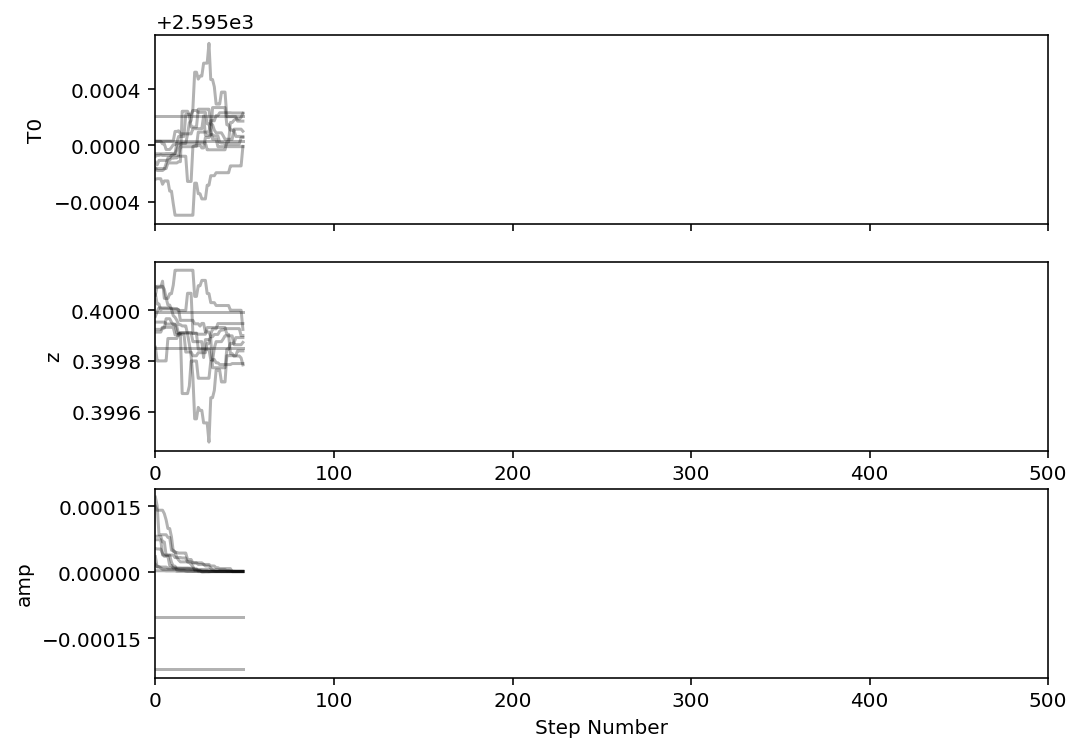

In [213]:
from matplotlib.ticker import MaxNLocator

samples = sampler.chain
labels = ['T0', 'z', 'amp', 'bkgd']

fig1 = plt.figure(figsize=[8, 8])
for i in range(samples.shape[-1]):
    ax = fig1.add_subplot(4, 1, i + 1)
    ax.plot(sampler.chain[:, 0:1000, i].T, "k", alpha=0.3)
    ax.set_xlim(0, sampler.chain.shape[1])
    if i < 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("Step Number")
    ax.set_ylabel(labels[i])
    ax.yaxis.set_major_locator(MaxNLocator(4))

    plt.xlim(0, 500)
fig1.show()

In [155]:
clean_samples = samples[:400, :400, :400]
samples.shape
np.median(clean_samples, axis=(0, 1))
flat_chain = clean_samples.reshape((-1, ndim))
flat_chain.shape

(500, 3)

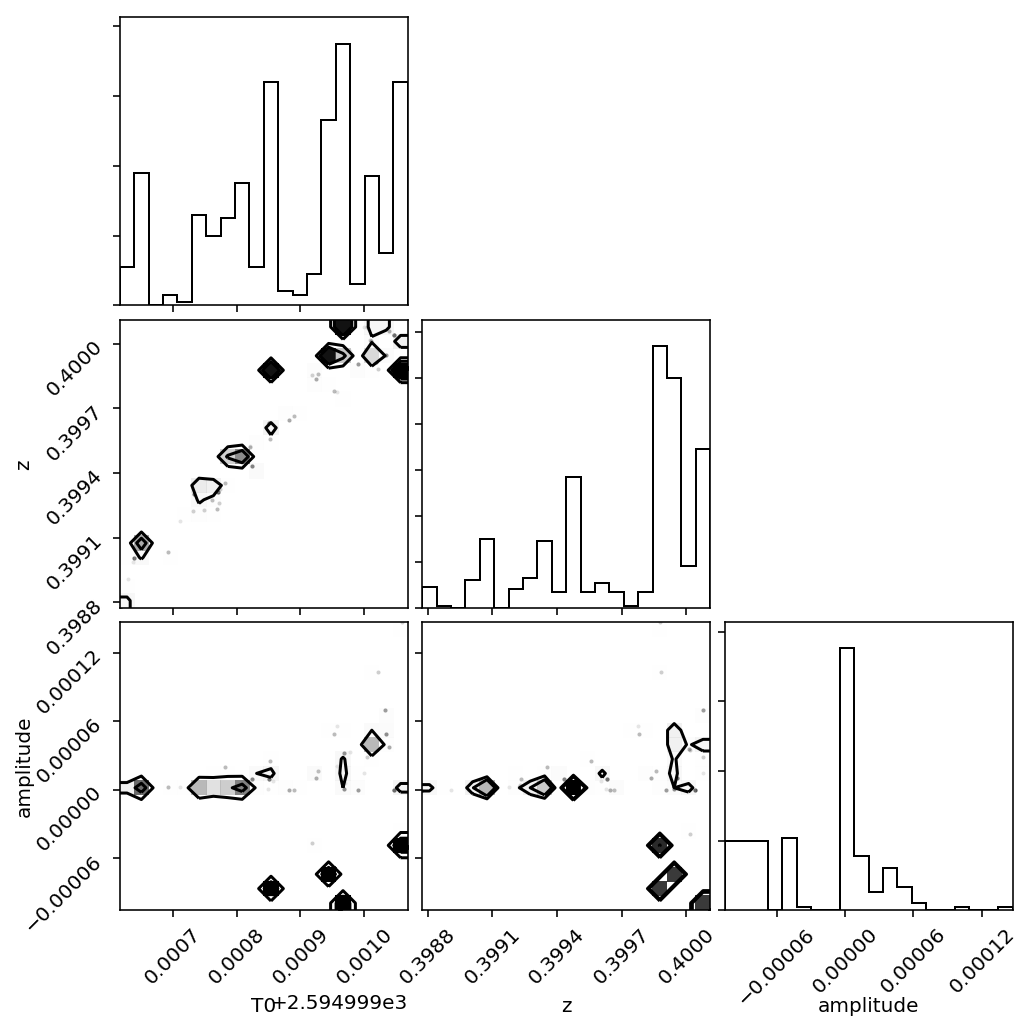

In [156]:
import corner
fig = corner.corner(flat_chain, labels=["T0", "z", "amplitude"])